In [1]:
import os
from glob import glob
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from python import prepare_inputs as pi
from python import solar_utils as su
from python import wind_utils as wu
from python import hydro_utils as hu
from python import climate_utils as cu
from python import utils as pu

from python.utils import project_path
from python.building_elec_model import building_types_dict

In [3]:
# Read zone shapefile for plots
nyiso_gdf = gpd.read_file(f"{project_path}/data/nyiso/gis/NYISO_Load_Zone_Dissolved.shp")

In [3]:
# Read run parameters
with open('./config.yml', 'r') as file:
    config = yaml.safe_load(file)

genX_file_name = config['genX_file_name']
genX_downscaled_file_name = config['genX_downscaled_file_name']
genX_iter = config['genX_iter']
busprop_name = config['busprop_name']
genprop_name = config['genprop_name']
climate_scenario_years = config['climate_scenario_years']
sim_years = config['sim_years']
resstock_upgrade = config['resstock_upgrade']
comstock_upgrade = config['comstock_upgrade']
run_name = config['run_name']

In [52]:
genX_file_name

'Combined_Capacity_S2_Low_RE_Mod_Elec'

# General

In [4]:
# Read genX
df_genX = pd.read_excel(f'{project_path}/data/genX/{genX_file_name}.xlsx')
df_genX = pi.tidy_genX(df_genX[df_genX['Iter'] == genX_iter]).query('EndCap > 1.')

In [5]:
df_genX.groupby('Resource')['EndCap'].sum()

Resource
battery                    5999.893968
biomass                     113.100000
distributed_generation     2553.998821
hydroelectric              4357.000000
hydroelectric_storage      1406.700000
natural_gas               16458.799716
nuclear                    2699.998092
offshore_wind              5737.997987
onshore_wind_existing      3388.999981
solar_existing             1706.399978
solar_new                 18648.858243
transportation              619.000000
water_heating               135.100000
Name: EndCap, dtype: float64

In [6]:
# Read GenX downscaled
df_genX_ds = pd.read_csv(f'{project_path}/data/genX/{genX_downscaled_file_name}.csv')

df_genX_ds = (df_genX_ds[(df_genX_ds['state'] == 'New York') & (df_genX_ds['iter'] == genX_iter)]
              .drop_duplicates(subset=['Resource', 'Zone'])
              .query('EndCap > 1.')
             )

In [9]:
df_genX_ds.groupby('technology')['EndCap'].sum()

technology
UtilityPV_Class1_Moderate_    18648.858243
Name: EndCap, dtype: float64

In [11]:
# Run name (make sure matches above!)
run_path = f"{project_path}/runs/{run_name}"

Path(f"{run_path}/inputs").mkdir(parents=True, exist_ok=True)
Path(f"{run_path}/outputs").mkdir(parents=True, exist_ok=True)
Path(f"{run_path}/figs").mkdir(parents=True, exist_ok=True)
Path(f"{run_path}/logs").mkdir(parents=True, exist_ok=True)

In [12]:
# Read ACORN generators
df_genprop_bo = pd.read_csv(f'{project_path}/data/grid/gen_prop_{busprop_name}.csv')
df_gencost_bo = pd.read_csv(f'{project_path}/data/grid/gencost_prop_{genprop_name}.csv')

# Merge costs and info
df_genprop = pd.merge(df_gencost_bo, df_genprop_bo)

# Select NYS only
df_genprop = df_genprop[df_genprop['GEN_ZONE'].isin(pu.zone_names)]

In [13]:
# Get climate input files
climate_paths = cu.generate_tgw_filelist(climate_scenario_years = climate_scenario_years,
                                         years = sim_years)

# Load

In [15]:
# Read baseline
df_baseline = pd.read_parquet(f"{project_path}/data/load/baseline/simulated/load_model_tgw_multizone_NN_{climate_scenario_years}.parquet")
df_baseline = df_baseline.groupby(['bus_id', 'datetime'])[['load_MW']].sum(numeric_only=True)

In [16]:
# Read ResStock
df_resstock = pd.concat([pd.read_parquet(f"{project_path}/data/load/resstock/simulated/bus_level/{climate_scenario_years}_{resstock_upgrade}_{home_type}.parquet") for home_type in building_types_dict['resstock']])
df_resstock = df_resstock.reset_index()
df_resstock = df_resstock.groupby(['bus_id','time']).sum()
df_resstock.index.names = ['bus_id', 'datetime']

In [17]:
# Read ComStock
df_comstock = pd.concat([pd.read_parquet(f"{project_path}/data/load/comstock/simulated/bus_level/{climate_scenario_years}_{comstock_upgrade}_{home_type}.parquet") for home_type in building_types_dict['comstock']])
df_comstock = df_comstock.reset_index()
df_comstock = df_comstock.groupby(['bus_id','time']).sum()
df_comstock.index.names = ['bus_id', 'datetime']

In [18]:
# Scale factors
genX_max_load = 27_055
resstock_scale_factor = float(0.5 * genX_max_load / df_resstock.groupby('datetime').sum().max())

In [19]:
# Combine
df_load = pd.concat([df_comstock.rename(columns={'bus_load_MW':'load_MW'}) * resstock_scale_factor,
                     df_resstock.rename(columns={'bus_load_MW':'load_MW'}) * resstock_scale_factor,
                     df_baseline]).groupby(['bus_id', 'datetime']).sum()

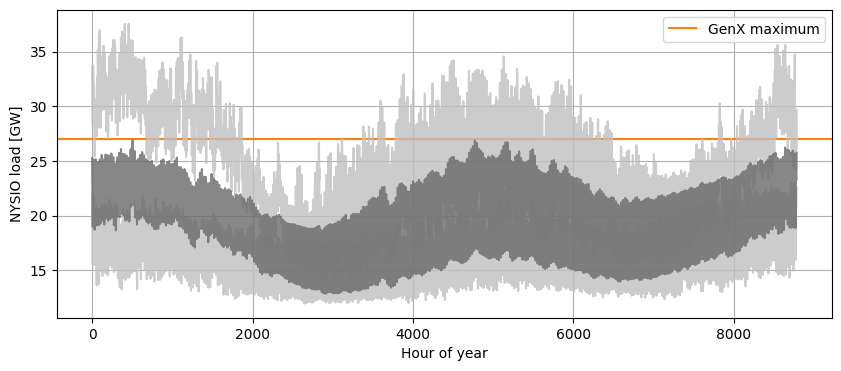

In [20]:
# Plot
df_load_hourly = df_load.groupby('datetime').sum().reset_index().copy()
df_load_hourly['hourofyear'] = df_load_hourly['datetime'].dt.hour + (df_load_hourly['datetime'].dt.dayofyear - 1) * 24
df_load_hourly['load_GW'] = df_load_hourly['load_MW']/1000

fig, ax = plt.subplots(figsize=(10,4))

ax.axhline(y=27, color='C1', label='GenX maximum')
ax.legend()

df_load_hourly.groupby('hourofyear')['load_GW'].min().plot(color='silver', ax=ax, alpha=0.8)
df_load_hourly.groupby('hourofyear')['load_GW'].max().plot(color='silver', ax=ax, alpha=0.8)
df_load_hourly.groupby('hourofyear')['load_GW'].mean().plot(color='dimgray', ax=ax, alpha=0.8)

ax.set_xlabel('Hour of year')
ax.set_ylabel('NYSIO load [GW]')
ax.grid(0.2)

plt.savefig(f"{run_path}/figs/load_timeseries.pdf", bbox_inches='tight')

In [21]:
# Store
df_load.reset_index().pivot(index='bus_id', 
                            columns='datetime', 
                            values='load_MW').to_csv(f"{run_path}/inputs/load_{climate_scenario_years}.csv")

# Non-renewable resources

## Storage

In [22]:
# Generate random sites per zone
df_genX_battery = pu.map_genX_zones_to_nyiso(df_genX[df_genX['Resource'] == 'battery'].copy(), genX_zone_col='Zone')
df_genX_battery = pi.generate_random_sites(df_genX_battery,
                                           sites_per_zone = 3,
                                           columns_to_scale = ['EndEnergyCap', 'EndCap'])

In [23]:
# Assign to random bus
df_genX_battery = pu.nearest_neighbor_lat_lon(df_genX_battery, PV_bus_only=False)

In [24]:
# Store
(
    df_genX_battery[['bus_id', 'EndCap', 'EndEnergyCap']]
    .groupby('bus_id').sum()
    .rename(columns={'EndCap':'charge_capacity_MW',
                     'EndEnergyCap':'storage_capacity_mwh'})
    .to_csv(f"{run_path}/inputs/storage_assignment.csv")
)

## Thermal

In [25]:
# Match thermal capacities (natural gas only)
df_ng_matched = pi.match_ng_capacity(df_genX,
                                     df_genprop,
                                     store_path = run_path,
                                     retirement_method='highest_cost_first')

Starting capacity matching process...

Capacity comparison:
Zone | Current (MW) | Target (MW) | Difference (MW)
-------------------------------------------------------
A    |       393.0 |      536.8 |         143.8
Zone A: Added 3 duplicate generators, increasing capacity by 149.0 MW (target: 143.8 MW)
B    |       109.0 |      269.1 |         160.1
Zone B: Added 3 duplicate generators, increasing capacity by 175.0 MW (target: 160.1 MW)
C    |      1709.0 |     1672.9 |         -36.1
Zone C: Retired 1 generators, reducing capacity by 110.0 MW (target: 36.1 MW)
D    |       346.0 |      371.0 |          25.0
Zone D: Added 1 duplicate generators, increasing capacity by 51.0 MW (target: 25.0 MW)
E    |       206.0 |      201.6 |          -4.4
Zone E: Retired 1 generators, reducing capacity by 45.0 MW (target: 4.4 MW)
F    |      3159.0 |     3797.5 |         638.5
Zone F: Added 2 duplicate generators, increasing capacity by 719.0 MW (target: 638.5 MW)
G    |      1761.0 |     2015.0 |   

In [26]:
# Store with only online generators
df_ng_matched = df_ng_matched[df_ng_matched['GEN_STATUS'] == 1].copy()
df_ng_matched.to_csv(f"{run_path}/inputs/genprop_ng_matched.csv", index=False)

## Nuclear

In [27]:
# GenX
df_genX.query('Resource == "nuclear"')[['Resource', 'Zone', 'EndCap']]

,Resource,Zone,EndCap
77178,nuclear,C&E,2699.998092


In [28]:
# ACORN
df_genprop[df_genprop['FUEL_TYPE'] == 'UR'][['GEN_NAME', 'PMAX', 'GEN_ZONE', 'GEN_STATUS']]

,GEN_NAME,PMAX,GEN_ZONE,GEN_STATUS
236,Indian Point 2,1026.5,H,1
237,Indian Point 3,1040.4,H,1
238,James A. FitzPatrick,858.9,C,1
239,Nine Mile Point 1,630.5,C,1
240,Nine Mile Point 2,1246.6,C,1
241,R. E. Ginna,582.0,B,1


In [29]:
# Match nuclear by hand -> keep only nuclear in zone C
# Retire all nuclear outside zone C
df_genprop_nuclear = df_genprop[(df_genprop['FUEL_TYPE'] == 'UR') & (df_genprop['GEN_ZONE'] == 'C')]
# Store
df_genprop_nuclear.to_csv(f"{run_path}/inputs/genprop_nuclear_matched.csv", index=False)

## Hydro

In [30]:
# First store the hydro generators
large_hydro_names = ['Moses Niagara (Fleet)', 'St Lawrence - FDR (Fleet)']

df_genprop_hydro = df_genprop[df_genprop['GEN_NAME'].isin(large_hydro_names)]
df_genprop_hydro.to_csv(f"{run_path}/inputs/genprop_hydro.csv", index=False)

In [31]:
# Get hourly hydro to buses
hydro_scenario = climate_scenario_years.split('_')[0]
df_small_hydro, df_large_hydro = hu.assign_hydro_GD_to_buses(hydro_scenario = hydro_scenario)

In [32]:
# Get max cap
acorn_small_hydro_cap = float(df_small_hydro.groupby('datetime').sum().max())
acorn_large_hydro_cap = float(df_large_hydro.groupby('datetime').sum().max() / (7*24))

In [33]:
# Store
df_small_hydro.reset_index().pivot(index='bus_id', 
                                   columns='datetime', 
                                   values='power_MW').to_csv(f"{run_path}/inputs/small_hydro_{hydro_scenario}.csv")

df_large_hydro.reset_index().pivot(index='bus_id', 
                                   columns='datetime', 
                                   values='power_predicted_mwh').to_csv(f"{run_path}/inputs/large_hydro_{hydro_scenario}.csv")

## Nameplate capacity comparison

In [34]:
# Construct plot df
genX_resources = df_genX['Resource'].unique()
genX_capacity = df_genX.groupby('Resource')['EndCap'].sum()

acorn_capacity = {'battery': genX_capacity['battery'],
                  'biomass': 0.0,
                  'hydroelectric': acorn_small_hydro_cap + acorn_large_hydro_cap,
                  'distributed_generation': genX_capacity['distributed_generation'],
                  'hydroelectric_storage': 0.0,
                  'natural_gas': df_ng_matched['PMAX'].sum(), 
                  'nuclear': df_genprop_nuclear['PMAX'].sum(),
                  'offshore_wind': genX_capacity['offshore_wind'],
                  'onshore_wind_existing': genX_capacity['onshore_wind_existing'],
                  'water_heating': 0.0,
                  'solar_existing': genX_capacity['solar_existing'],
                  'transportation': 0.0,
                  'solar_new': genX_capacity['solar_new'], 
                 }

df_cap_plot = pd.DataFrame({'GenX': [genX_capacity[res] for res in genX_resources],
                            'ACORN': [acorn_capacity[res] for res in genX_resources]},
                           index=genX_resources)

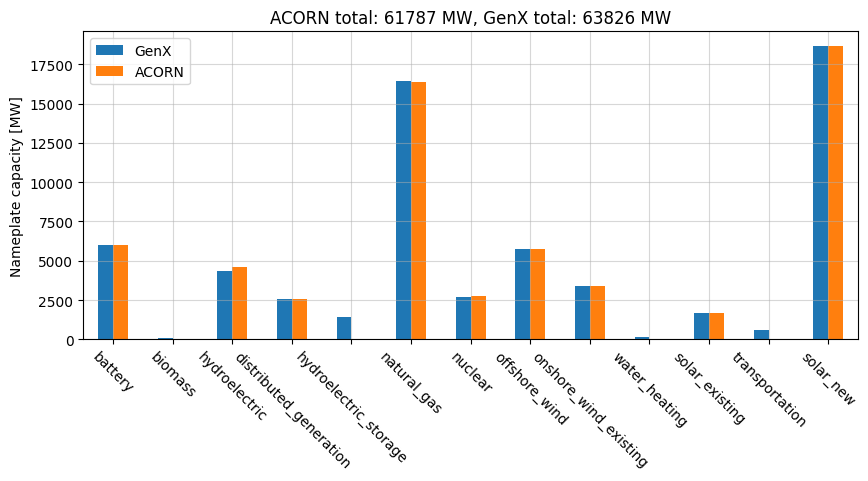

In [35]:
fig, ax = plt.subplots(figsize=(10,4))

df_cap_plot.plot.bar(rot=-45, ax=ax)

ax.grid(alpha=0.5)
ax.set_ylabel('Nameplate capacity [MW]')

ax.set_title(f'ACORN total: {df_cap_plot['ACORN'].sum():.0f} MW, GenX total: {df_cap_plot['GenX'].sum():.0f} MW')

plt.savefig(f"{run_path}/figs/capacity_comparison.pdf", bbox_inches='tight')

# Renewable resources

## Solar

### DPV

In [36]:
#######################
# Existing solar: DPV
#######################
# Generate existing sites
df_genX_solar_dpv = pu.map_genX_zones_to_nyiso(df_genX[df_genX['Resource'] == 'distributed_generation'].copy(),
                                               genX_zone_col='Zone')

df_genX_solar_dpv = pi.generate_random_sites(df_genX_solar_dpv, sites_per_zone=10)

# Correction factors
correction_file = f"{project_path}/data/solar/models/tgw_solar_correction_factors.csv"

# Calculate the timeseries
df_solar_dpv = su.calculate_solar_timeseries_from_genX(
    df_genX = df_genX_solar_dpv,
    climate_paths = climate_paths,
    correction_file = correction_file,
    PV_bus_only = False
)

# Store
df_solar_dpv.reset_index().pivot(index='bus_id', 
                             columns='datetime', 
                             values='power_MW').to_csv(f"{run_path}/inputs/solar_dpv_{climate_scenario_years}.csv")

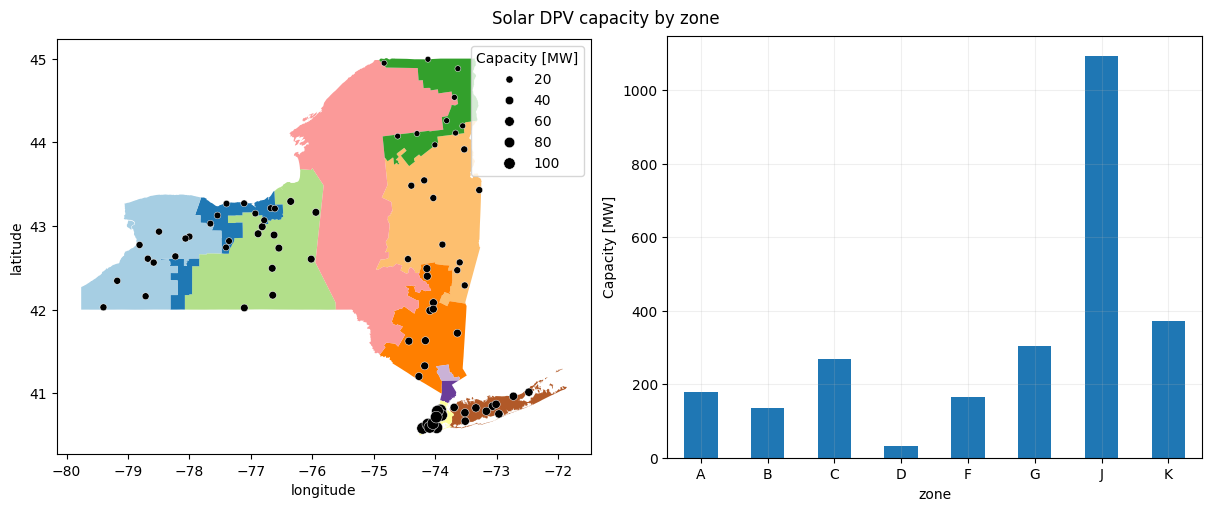

In [37]:
# Plot DPV
fig, axs = plt.subplots(1, 2, figsize=(12,5), layout='constrained')
fig.suptitle('Solar DPV capacity by zone')

# Map
ax=axs[0]
nyiso_gdf.plot(ax=ax, column='zone', cmap='Paired')
sns.scatterplot(data=df_genX_solar_dpv, x='longitude', y='latitude', size='EndCap', color='black', ax=ax)
leg = ax.legend(title='Capacity [MW]')

# Bar
ax=axs[1]
df_genX_solar_dpv.groupby('zone')['EndCap'].sum().plot.bar(ax=axs[1], rot=0)
ax.set_ylabel('Capacity [MW]')
ax.grid(alpha=0.2)

plt.savefig(f"{run_path}/figs/solar_dpv.pdf", bbox_inches='tight')

### UPV

In [38]:
######################
# Existing solar: UPV
######################
# Generate existing sites
df_genX_solar_existing = pu.map_genX_zones_to_nyiso(df_genX[df_genX['Resource'] == 'solar_existing'].copy(),
                                                   genX_zone_col='Zone')

df_genX_solar_existing = pi.generate_random_sites(df_genX_solar_existing, sites_per_zone=1)

# Correction factors
correction_file = f"{project_path}/data/solar/models/tgw_solar_correction_factors.csv"

# Calculate the timeseries
df_solar_existing = su.calculate_solar_timeseries_from_genX(
    df_genX = df_genX_solar_existing,
    climate_paths = climate_paths,
    correction_file = correction_file,
)

In [39]:
# ################################################################
# # NOTE: The genX zones do not always align with their coordinates
# # (i.e. they will be assigned to a different zone).
# # When aggregating to bus level, assigning `match_zone` = True (default)
# # means that genX zones will be respected. `match_zone` = False
# # means it will use the lat/lon coords instead.
# ################################################################
# # Read NYISO shapefile
# nyiso_gdf = gpd.read_file(f'{project_path}/data/nyiso/gis/NYISO_Load_Zone_Dissolved.shp')

# # Plot
# fig, axs = plt.subplots(1,2, figsize=(15,10))

# nyiso_gdf.plot(ax=axs[0])
# pu.merge_to_zones(df_genX_ds[df_genX_ds['Resource_Type'] == 'Utility_PV'],
#                lat_name='latitude',
#                lon_name='longitude').plot(ax=axs[0], column='region', legend=True, cmap='Paired')

# nyiso_gdf.plot(ax=axs[1], column='zone', legend=True, cmap='Paired')

# plt.show()

In [41]:
####################
# New solar: UPV
####################
# Update the genX regions
df_genX_ds_solar = df_genX_ds[df_genX_ds['technology'] == 'UtilityPV_Class1_Moderate_'].copy()
df_genX_ds_solar = pu.map_genX_zones_to_nyiso(df_genX_ds_solar, C_and_E_mapping='C')

# Correction factors
correction_file = f"{project_path}/data/solar/models/tgw_solar_correction_factors.csv"

# Calculate the timeseries
df_solar_new = su.calculate_solar_timeseries_from_genX(
    df_genX = df_genX_ds_solar,
    climate_paths = climate_paths,
    correction_file = correction_file,
)

In [42]:
# Combined solar
df_solar_total = pd.concat([df_solar_existing, df_solar_new])
df_solar_total = df_solar_total.reset_index().groupby(['bus_id', 'datetime']).sum()

# Store combined
df_solar_total.reset_index().pivot(index='bus_id', 
                             columns='datetime', 
                             values='power_MW').to_csv(f"{run_path}/inputs/solar_upv_{climate_scenario_years}.csv")

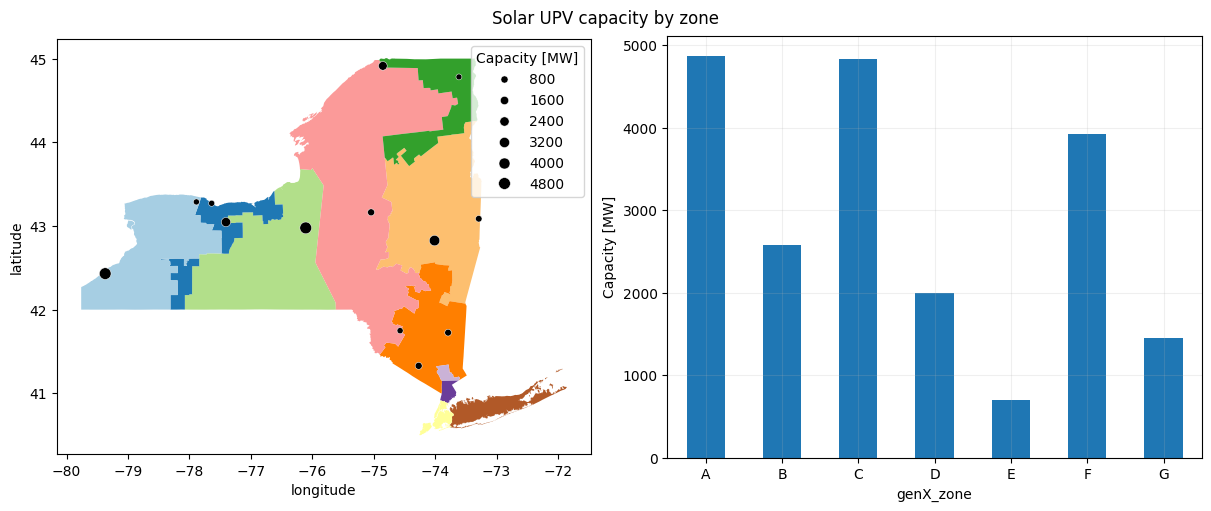

In [43]:
# Plot UPV
fig, axs = plt.subplots(1, 2, figsize=(12,5), layout='constrained')
fig.suptitle('Solar UPV capacity by zone')

df_solar_upv_plot = pd.concat([df_genX_ds_solar, df_genX_solar_existing])

# Map
ax = axs[0]

nyiso_gdf.plot(ax=ax, column='zone', cmap='Paired')
sns.scatterplot(data=df_solar_upv_plot, x='longitude', y='latitude', size='EndCap', color='black', ax=ax)
leg = ax.legend(title='Capacity [MW]')

# Bar
ax = axs[1]
df_solar_upv_plot.groupby('genX_zone')['EndCap'].sum().plot.bar(ax=axs[1], rot=0)
ax.set_ylabel('Capacity [MW]')
ax.grid(alpha=0.2)

plt.savefig(f"{run_path}/figs/solar_upv.pdf", bbox_inches='tight')

## Wind

### Onshore

In [45]:
########################
# Existing onshore wind
########################
# Generate existing onshore sites
df_genX_onshore_existing = pu.map_genX_zones_to_nyiso(df_genX[df_genX['Resource'] == 'onshore_wind_existing'].copy(),
                                                      genX_zone_col='Zone')

df_genX_onshore_existing = wu.generate_onshore_wind_sites(df_genX_onshore_existing)

# Stability coefficients
stab_coef_file = f"{pu.project_path}/data/wind/models/tgw_stability_coefficients_2007-2013_every5.csv"

# Calculate the timeseries
df_onshore_wind = wu.calculate_wind_timeseries_from_genX(
    df_genX = df_genX_onshore_existing,
    climate_paths = climate_paths,
    stab_coef_file = stab_coef_file,
    iec_curve = 'iec1',
)

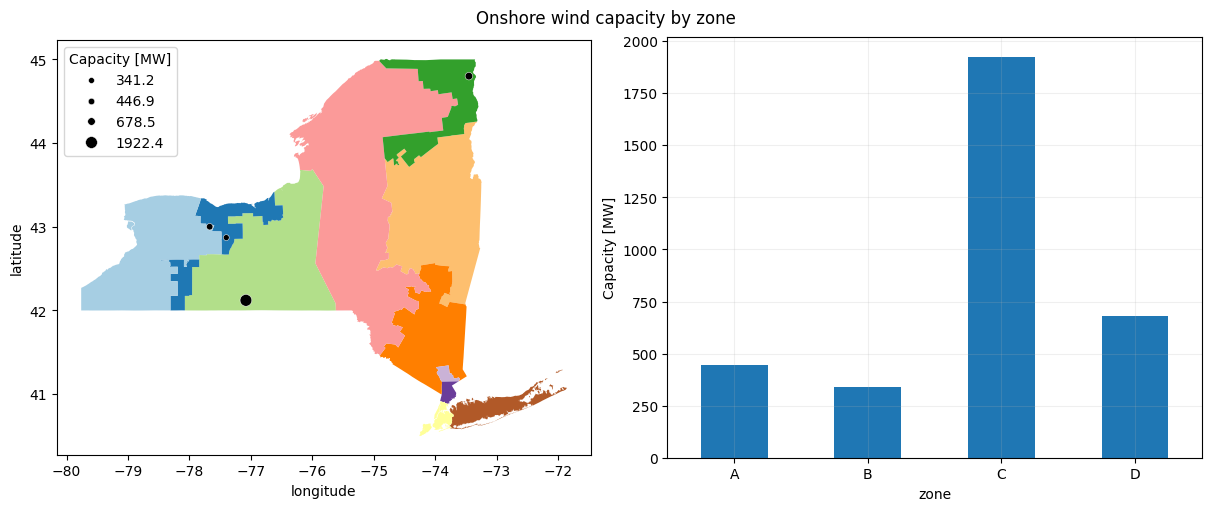

In [46]:
# Plot onshore wind
fig, axs = plt.subplots(1, 2, figsize=(12,5), layout='constrained')
fig.suptitle('Onshore wind capacity by zone')

# Map
ax = axs[0]

nyiso_gdf.plot(ax=ax, column='zone', cmap='Paired')
sns.scatterplot(data=df_genX_onshore_existing.round(2), x='longitude', y='latitude', size='EndCap', color='black', ax=ax)
leg = ax.legend(title='Capacity [MW]', loc='upper left')

# Bar
ax = axs[1]
df_genX_onshore_existing.groupby('zone')['EndCap'].sum().plot.bar(ax=axs[1], rot=0)
ax.set_ylabel('Capacity [MW]')
ax.grid(alpha=0.2)

plt.savefig(f"{run_path}/figs/onshore_wind.pdf", bbox_inches='tight')

### Offshore

ERROR! Session/line number was not unique in database. History logging moved to new session 631


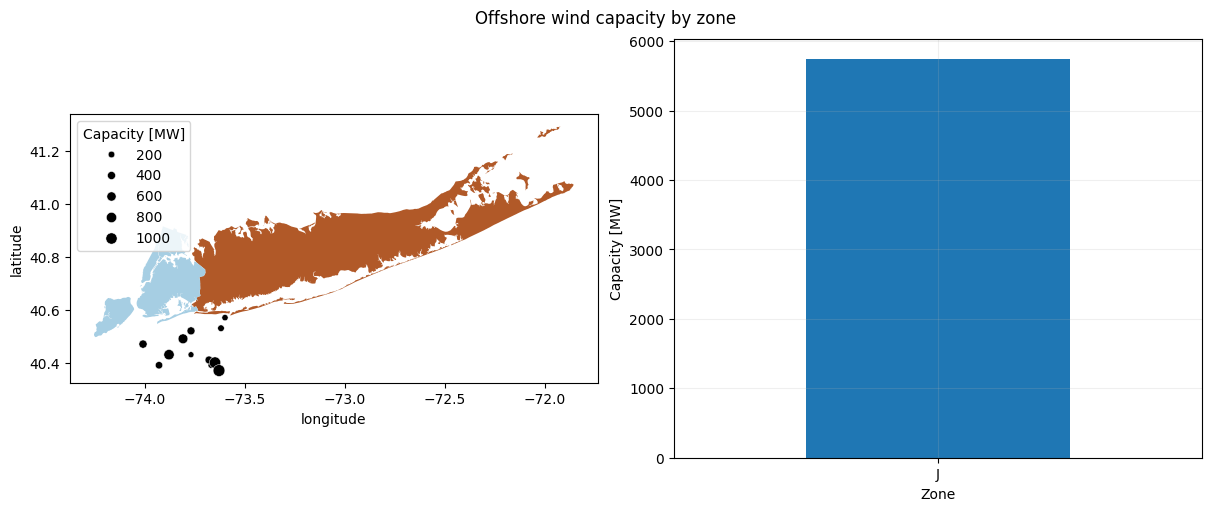

In [49]:
### Generate sites
# Generate offshore locations
df_genX_offshore_existing = pu.map_genX_zones_to_nyiso(df_genX[df_genX['Resource'] == 'offshore_wind'].copy(),
                                                      genX_zone_col='Zone')

df_genX_offshore_existing = wu.generate_offshore_wind_sites(df_genX_offshore_existing)

# Plot offshore wind
fig, axs = plt.subplots(1, 2, figsize=(12,5), layout='constrained')
fig.suptitle('Offshore wind capacity by zone')

# Map
ax = axs[0]

nyiso_gdf[nyiso_gdf['zone'].isin(['J', 'K'])].plot(ax=ax, column='zone', cmap='Paired')
sns.scatterplot(data=df_genX_offshore_existing.round(2), x='longitude', y='latitude', size='EndCap', color='black', ax=ax)
leg = ax.legend(title='Capacity [MW]', loc='upper left')

# Bar
ax = axs[1]
df_genX_offshore_existing.groupby('Zone')['EndCap'].sum().plot.bar(ax=axs[1], rot=0)
ax.set_ylabel('Capacity [MW]')
ax.grid(alpha=0.2)

plt.savefig(f"{run_path}/figs/offshore_wind.pdf", bbox_inches='tight')

In [50]:
## Generate timeseries
# Stability coefficients
stab_coef_file = f"{pu.project_path}/data/wind/models/tgw_stability_coefficients_2007-2013_every5.csv"

# Calculate the timeseries
df_offshore_wind = wu.calculate_wind_timeseries_from_genX(
    df_genX = df_genX_offshore_existing,
    climate_paths = climate_paths,
    stab_coef_file = stab_coef_file,
    iec_curve = 'offshore',
)

In [51]:
# Combined wind
df_wind_total = pd.concat([df_onshore_wind, df_offshore_wind])
df_wind_total = df_wind_total.reset_index().groupby(['bus_id', 'datetime']).sum()

# Store combined
df_wind_total.reset_index().pivot(index='bus_id', 
                             columns='datetime', 
                             values='power_MW').to_csv(f"{run_path}/inputs/wind_{climate_scenario_years}.csv")